In [1981]:
from sympy import init_session
import math
import matplotlib.pyplot as plt
import sys
import ipywidgets as widgets
import numpy as np
import imageio.v2 as imageio
from IPython.display import Image
import pandas as pd
import seaborn as sns
import scipy.integrate as it
init_session(use_latex = True)

IPython console for SymPy 1.13.2 (Python 3.10.1-64-bit) (ground types: gmpy)

These commands were executed:
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at https://docs.sympy.org/1.13.2/



In [1982]:
# Size
a = 1.97 * 0.0254 #m R2
b = 12.4 * 0.0254 #m R3
c = 3.17 * 0.0254 #m R4
d = 13.4 * 0.0254 #m R1
a, b, c, d

In [1983]:
m = 3.48 #kg
l = 24.5 * 0.0254 #length of wiper m
I = 1/12 * m * l**2 + 1/12 * m * l**2 + m* (l/2 * (2**0.5))**2#moment of inertia about com kgm^2
mu_k = 0.3  # coefficient of kinetic friction
g = 9.81  # gravity (m/s^2)
theta = 23 #degs

In [1984]:
#Parameters
motor_torque = 30 #NM 
df = pd.read_csv("4bardata.txt", sep='\t' , header = None, names = ["time [s]", "theta_2 [rad]", "theta_3 [rad]", "theta_4 [rad]", "theta_2 [°]","theta_3 [°]","theta_4 [°]","omega_2 [rad/s]", "omega_43 [rad/s]","omega_4 [rad/s]","alpha_2 [rad/s^2]","alpha_3 [rad/s^2]","alpha_4 [rad/s^2]"])
#df.head(20)
#print(df.shape[0])
list(df)

['time [s]',
 'theta_2 [rad]',
 'theta_3 [rad]',
 'theta_4 [rad]',
 'theta_2 [°]',
 'theta_3 [°]',
 'theta_4 [°]',
 'omega_2 [rad/s]',
 'omega_43 [rad/s]',
 'omega_4 [rad/s]',
 'alpha_2 [rad/s^2]',
 'alpha_3 [rad/s^2]',
 'alpha_4 [rad/s^2]']

In [1985]:
#Torque Calculations
f1 = []
theta_a = []
for i in range(df.shape[0]):
    theta_a = abs(180 - df["theta_2 [°]"][i] + df["theta_3 [°]"][i]) # inner angle between link a and b
    #print(theta_a)
    if ((df["theta_2 [°]"][i])>0).any() & ((df["theta_2 [°]"][i])<= 90).any(): 
       #print("bug")
       
        if theta_a > 90 and theta_a <= 180: 
            #print("bug")
            temp4 = motor_torque * (np.sin(np.radians(df["theta_2 [°]"][i])) * a)
            f1.append(temp4)  
        elif theta_a > 180 and theta_a <= 270: 
            
            temp3 = motor_torque * (np.sin(np.radians(df["theta_2 [°]"][i])) * a)
            f1.append(temp3)  
        
    elif ((df["theta_2 [°]"][i])>90).any() & ((df["theta_2 [°]"][i])<= 180).any() : 
        
        if theta_a > 0 and theta_a <= 90: 
            
            if (df["theta_2 [°]"][i] > theta_a).any():
                
                temp13 = motor_torque * (np.sin(np.radians(theta_a)) * a) 
                f1.append(temp13)
        elif theta_a > 90 and theta_a <= 180: 
            if (df["theta_2 [°]"][i] > theta_a).any():
                temp14 = motor_torque * (np.sin(np.radians(theta_a)) * a) 
                f1.append(temp14)
            else:
                temp15 = motor_torque * (np.sin(np.radians(df["theta_2 [°]"][i])) * a) 
                f1.append(temp15)

    elif ((df["theta_2 [°]"][i])>270).any() & ((df["theta_2 [°]"][i])<= 360).any() : 
        if theta_a > 0 and theta_a <= 90: 
            if (df["theta_2 [°]"][i] > theta_a).any():
                
                temp16 = motor_torque * (np.sin(np.radians(theta_a)) * a) 
                f1.append(temp16)
        elif theta_a > 90 and theta_a <= 180: 
            #print("bug")
            if (df["theta_2 [°]"][i] > theta_a).any():
                
                temp18 = motor_torque * (np.sin(np.radians(180- theta_a)) * a) 
                f1.append(temp18)
 
    elif ((df["theta_2 [°]"][i])>180).any() & ((df["theta_2 [°]"][i])<= 270).any() : 
        if theta_a > 0 and theta_a < 90:
            if (df["theta_2 [°]"][i] > theta_a).any():
                #print("bug")
                temp19 = motor_torque * (np.sin(np.radians(theta_a)) * a) 
                f1.append(temp19)
    
print(len(f1))

tau_out = []
theta_b = []
for j in range(df.shape[0]):
    theta_b =  (df["theta_4 [°]"][j]- df["theta_3 [°]"][j]) # inner angle between link b and c
    if ((df["theta_4 [°]"][j]) > 0).any() & ((df["theta_4 [°]"][j]) <= 90).any():
        temp5 = f1[j] * np.sin(np.radians(theta_b)) * c
        tau_out.append(temp5)  
    elif((df["theta_4 [°]"][j]) > 90).any() & ((df["theta_4 [°]"][j]) <= 180).any():
        
        temp6 = f1[j] * np.sin(np.radians(180 - theta_b)) * c
        tau_out.append(temp6) 
  

301


In [1986]:
# Equations of Motion
# Moment about G (insert correct variables)
# Reordered the equation I * df["alpha_4 rad/s^2"] = tau_out - mu_k * F_n * l/2 to solve for F_n
acceleration_x = []
acceleration_y = []
a_mag = []
F_n = []
F_friction = []

for i in range(df.shape[0]):
    temp7 = - 2 * (I * df["alpha_4 [rad/s^2]"][i] - tau_out[i]) / (mu_k * l) #Normal Force
    F_n.append(temp7)
    # Sum of Forces x

    temp8 = 1/m * (tau_out[i]/l - F_n[i] * mu_k ) #Tangential Acceleration
    acceleration_x.append(temp8)

    # Sum of Forces y
    # Reordered the equation m * acceleration_y = F_n - m * g * np.cos(25 * (pi/180)) to solve for acceleration_y
    temp11 = F_n[i] / m - g * np.cos(np.radians(theta)) #Normal Acceleration
    acceleration_y.append(temp11)
    
    temp9 = (acceleration_y[i]**2 + acceleration_y[i]**2)**0.5 #Acceleration magnitude
    a_mag.append(temp9)
    
    # Friction
    temp12 = mu_k * F_n[i]
    F_friction.append(temp12)
    # linear position

df["F_normal [N]"] = F_n
df["Friction [N]"] = F_friction
df["acc_tan [m/s^2]"] = acceleration_x
df["acc_nor [m/s^2]"] = acceleration_y
df["acc_mag [m/s^2]"] = a_mag
df.head()



,time [s],theta_2 [rad],theta_3 [rad],theta_4 [rad],theta_2 [°],theta_3 [°],theta_4 [°],omega_2 [rad/s],omega_43 [rad/s],omega_4 [rad/s],alpha_2 [rad/s^2],alpha_3 [rad/s^2],alpha_4 [rad/s^2],F_normal [N],Friction [N],acc_tan [m/s^2],acc_nor [m/s^2],acc_mag [m/s^2]
0,0.00,4.712389,0.374592,2.197779,270.000000,21.462533,125.923486,6.81,0.655531,-4.067483,0.0,-10.640384,-4.887655,48.210117,14.463035,-4.105747,4.823329,6.821218
1,0.01,4.712389,0.374592,2.197779,270.000000,21.462533,125.923486,6.81,0.655531,-4.067483,0.0,-10.640384,-4.887655,48.210117,14.463035,-4.105747,4.823329,6.821218
2,0.02,4.780489,0.380609,2.156869,273.901843,21.807267,123.579504,6.81,0.547185,-4.113627,0.0,-11.020230,-4.328158,42.864343,12.859303,-3.643209,3.287187,4.648785
3,0.03,4.848589,0.385524,2.115527,277.803685,22.088886,121.210765,6.81,0.435307,-4.153755,0.0,-11.345834,-3.681429,36.672368,11.001711,-3.108008,1.507884,2.132470
4,0.04,4.916689,0.389305,2.073817,281.705528,22.305527,118.820983,6.81,0.320474,-4.186905,0.0,-11.609664,-2.929573,29.461411,8.838423,-2.485271,-0.564230,0.797942


In [1987]:
#Use Simpson's Rule 1/3 to find v by integration
dt = 0.01
v_tan = it.cumulative_trapezoid(y = df["acc_tan [m/s^2]"], x = df["time [s]"], dx = dt, initial = 0)
v_nor = it.cumulative_trapezoid(y = df["acc_nor [m/s^2]"], x = df["time [s]"], dx = dt, initial = 0)
df["vel_tan [m/s]"] = v_tan
df["vel_nor [m/s]"] = v_nor


In [1988]:
#Use Simpson's Rule 1/3 to find position by integration
dt = 0.01
tan = it.cumulative_trapezoid(y = df["vel_tan [m/s]"], x = df["time [s]"],dx = dt, initial = 0)
nor = it.cumulative_trapezoid(y = df["vel_nor [m/s]"], x = df["time [s]"],dx = dt, initial = 0)
df["pos_tan [m]"] = tan
df["pos_nor [m]"] = nor

In [1989]:
df.head()

,time [s],theta_2 [rad],theta_3 [rad],theta_4 [rad],theta_2 [°],theta_3 [°],theta_4 [°],omega_2 [rad/s],omega_43 [rad/s],omega_4 [rad/s],...,alpha_4 [rad/s^2],F_normal [N],Friction [N],acc_tan [m/s^2],acc_nor [m/s^2],acc_mag [m/s^2],vel_tan [m/s],vel_nor [m/s],pos_tan [m],pos_nor [m]
0,0.00,4.712389,0.374592,2.197779,270.000000,21.462533,125.923486,6.81,0.655531,-4.067483,...,-4.887655,48.210117,14.463035,-4.105747,4.823329,6.821218,0.000000,0.000000,0.000000,0.000000
1,0.01,4.712389,0.374592,2.197779,270.000000,21.462533,125.923486,6.81,0.655531,-4.067483,...,-4.887655,48.210117,14.463035,-4.105747,4.823329,6.821218,-0.041057,0.048233,-0.000205,0.000241
2,0.02,4.780489,0.380609,2.156869,273.901843,21.807267,123.579504,6.81,0.547185,-4.113627,...,-4.328158,42.864343,12.859303,-3.643209,3.287187,4.648785,-0.079802,0.088786,-0.000810,0.000926
3,0.03,4.848589,0.385524,2.115527,277.803685,22.088886,121.210765,6.81,0.435307,-4.153755,...,-3.681429,36.672368,11.001711,-3.108008,1.507884,2.132470,-0.113558,0.112761,-0.001776,0.001934
4,0.04,4.916689,0.389305,2.073817,281.705528,22.305527,118.820983,6.81,0.320474,-4.186905,...,-2.929573,29.461411,8.838423,-2.485271,-0.564230,0.797942,-0.141525,0.117480,-0.003052,0.003085


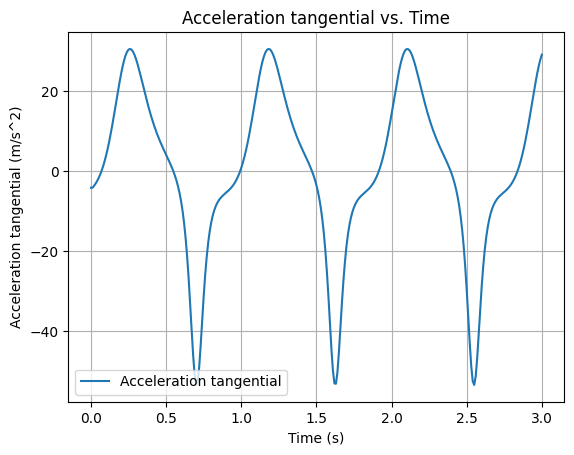

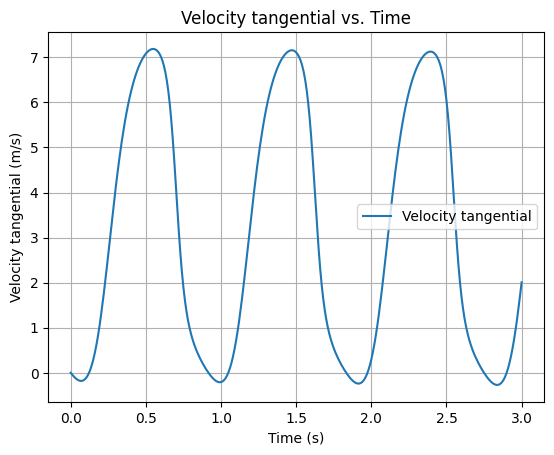

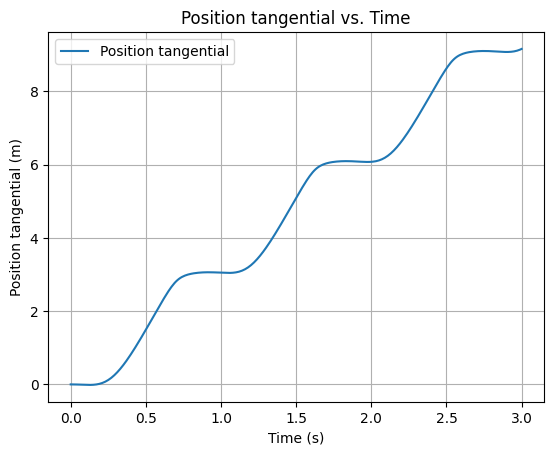

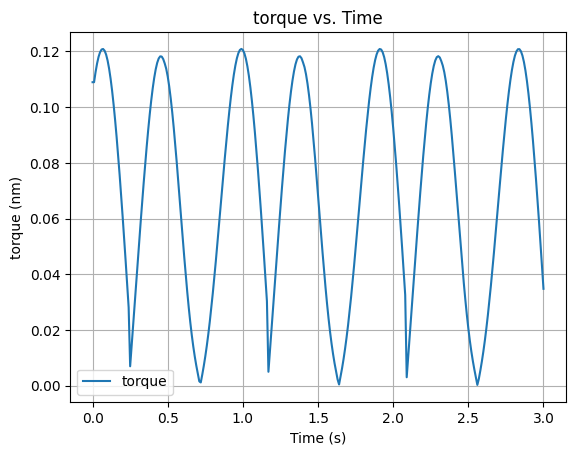

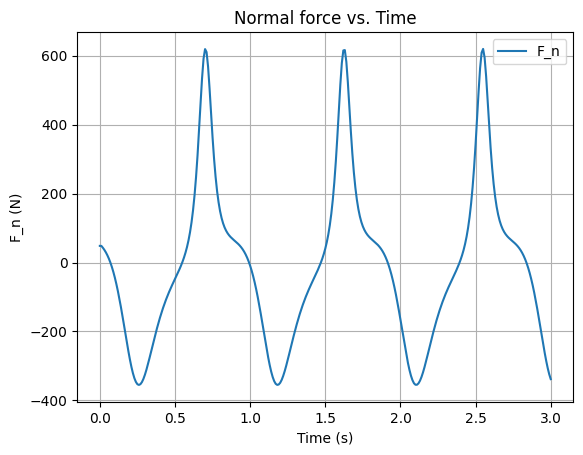

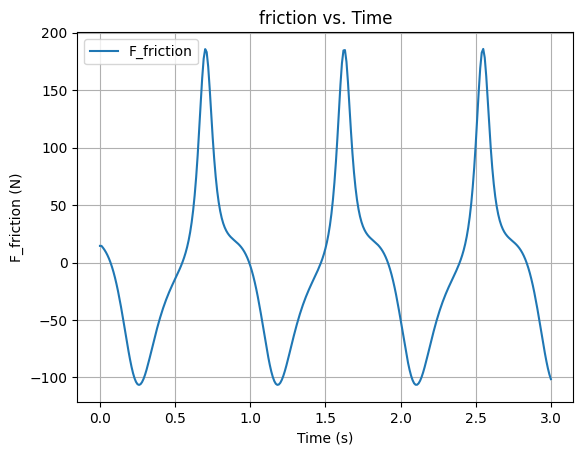

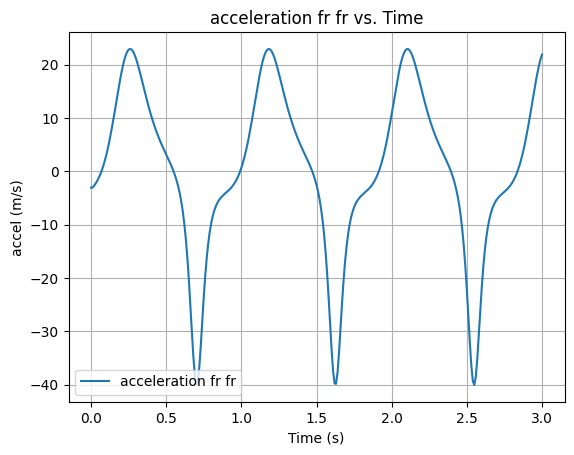

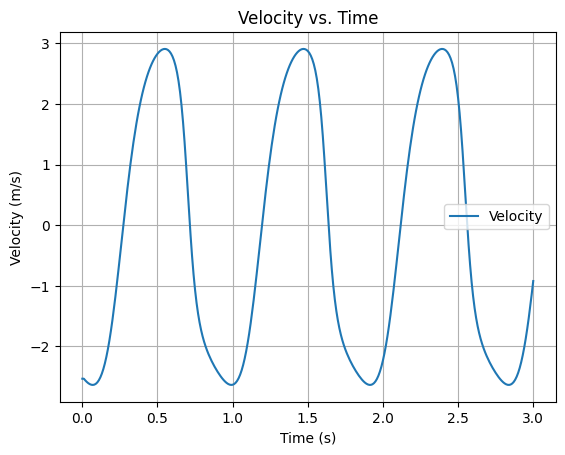

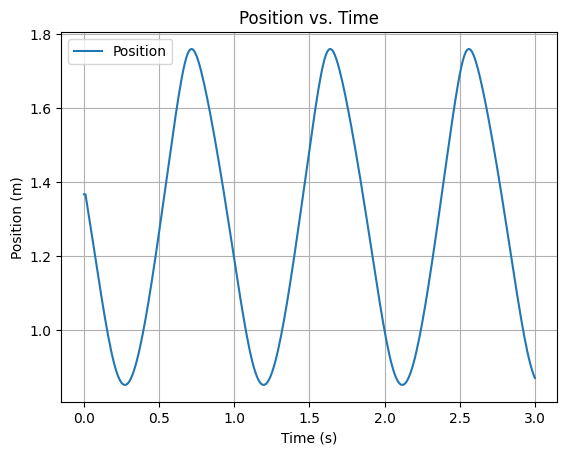

In [1990]:
# Plotting the graphs

plt.plot(df["time [s]"], df["acc_tan [m/s^2]"], label='Acceleration tangential')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration tangential (m/s^2)')
plt.title('Acceleration tangential vs. Time')
plt.legend()
plt.grid()
plt.show()

plt.plot(df["time [s]"], df["vel_tan [m/s]"] , label='Velocity tangential')
plt.xlabel('Time (s)')
plt.ylabel('Velocity tangential (m/s)')
plt.title('Velocity tangential vs. Time')
plt.legend()
plt.grid()
plt.show()

plt.plot(df["time [s]"], df["pos_tan [m]"] , label='Position tangential')
plt.xlabel('Time (s)')
plt.ylabel('Position tangential (m)')
plt.title('Position tangential vs. Time')
plt.legend()
plt.grid()
plt.show()

plt.plot(df["time [s]"], tau_out, label='torque')
plt.xlabel('Time (s)')
plt.ylabel('torque (nm)')
plt.title('torque vs. Time')
plt.legend()
plt.grid()
plt.show()

plt.plot(df["time [s]"], F_n, label='F_n')
plt.xlabel('Time (s)')
plt.ylabel('F_n (N)')
plt.title('Normal force vs. Time')
plt.legend()
plt.grid()
plt.show()

plt.plot(df["time [s]"], F_friction, label='F_friction')
plt.xlabel('Time (s)')
plt.ylabel('F_friction (N)')
plt.title('friction vs. Time')
plt.legend()
plt.grid()
plt.show()

plt.plot(df["time [s]"], l * df["alpha_4 [rad/s^2]"], label='acceleration fr fr')
plt.xlabel('Time (s)')
plt.ylabel('accel (m/s)')
plt.title('acceleration fr fr vs. Time')
plt.legend()
plt.grid()
plt.show()

plt.plot(df["time [s]"], l * df["omega_4 [rad/s]"], label='Velocity')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('Velocity vs. Time')
plt.legend()
plt.grid()
plt.show()

plt.plot(df["time [s]"], l * df["theta_4 [rad]"], label='Position')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.title('Position vs. Time')
plt.legend()
plt.grid()
plt.show()